In [5]:
from sklearn.linear_model import Lasso,BayesianRidge, LassoLarsIC, LinearRegression, RidgeCV, \
LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import sklearn.model_selection as ms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

from scipy import stats
import pylab 
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')
from cleaning import *

ModuleNotFoundError: No module named 'cleaning'

## Correlation of features

In [2]:
?sns.heatmap

SyntaxError: invalid character in identifier (<ipython-input-2-13cadc0f594e>, line 1)

In [3]:
train_test_data = pd.read_csv('train_test_data.csv').iloc[:,1:]
sns.heatmap(train_test_data.corr())

NameError: name 'pd' is not defined

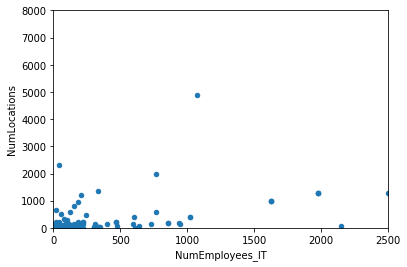

In [42]:
df = train_test_data
var = 'NumEmployees_IT'
data = pd.concat([df['NumLocations'], df[var]], axis=1)
data.plot.scatter(x=var, y='NumLocations', xlim= (0, 2500), ylim=(0,8000))

## Two sets used - We can change this later depending on the model outcome

In [43]:
df = train_test_data[train_test_data.Status != "New"][["NAICS","Industry","Revenue","budget_IT","budget_MK","budget_FI","SalesGrowth","NumLocations",
        "NumEmployees","NumEmployees_IT","EmployeeGrowth","GlobalRank","BusinessModel","FortuneRank",
       "Country","Ecommerce","IsQual"]]

In [44]:
df2 = df[["Revenue","budget_IT","budget_MK","budget_FI","SalesGrowth","NumLocations",
        "NumEmployees","NumEmployees_IT","EmployeeGrowth","GlobalRank","FortuneRank","IsQual"]]

## missingness

In [45]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [46]:
missing_values_table(df)

Your selected dataframe has 17 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
GlobalRank,1679,95.5
FortuneRank,1673,95.2
NumLocations,1612,91.7
EmployeeGrowth,1049,59.7
SalesGrowth,1046,59.5
Ecommerce,573,32.6
budget_IT,201,11.4
NumEmployees_IT,201,11.4
budget_MK,166,9.4
budget_FI,161,9.2


In [33]:
missing_values_table(df2)

Your selected dataframe has 12 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
GlobalRank,1679,95.5
FortuneRank,1673,95.2
NumLocations,1612,91.7
EmployeeGrowth,1049,59.7
SalesGrowth,1046,59.5
budget_IT,201,11.4
NumEmployees_IT,201,11.4
budget_MK,166,9.4
budget_FI,161,9.2


In [14]:
df.sample(10)

,NAICS,Industry,Revenue,budget_IT,budget_MK,budget_FI,SalesGrowth,NumLocations,NumEmployees,NumEmployees_IT,EmployeeGrowth,GlobalRank,BusinessModel,FortuneRank,Country,Ecommerce,IsQual
2790,541512.0,IT Services,13300000,0.492,1.077,NaN,NaN,1.0,64,2.0,NaN,NaN,B2B,NaN,United States,"IBM WebSphere Commerce, wix, WixStores",False
913,487210.0,Travel & Tourism,21546972,NaN,2.478,0.215,NaN,NaN,45,NaN,NaN,NaN,B2C,NaN,United States,"WooCommerce, Yoast",False
2294,339112.0,Medical Devices,2000000,0.074,0.262,NaN,NaN,NaN,21,1.0,NaN,NaN,B2B,NaN,United States,Yoast,False
3158,523110.0,Banking,143200000000,"7,248.960","10,470.720","1,006.800",0.0,NaN,352621,26824.0,0.0,2.0,B2B/B2C,NaN,China,NaN,False
2006,561599.0,Professional Services,17000000,0.799,1.309,0.170,0.0,NaN,90,4.0,0.0,NaN,B2B/B2C,NaN,United States,Optanon,False
1189,488510.0,Logistics / Transportation,9797283,0.245,0.588,0.098,0.0,NaN,30,1.0,0.0,NaN,B2B,NaN,United States,"Crazy Egg, Yoast",False
682,541512.0,Computer Software,10000000,0.370,1.310,0.100,NaN,NaN,30,2.0,NaN,NaN,B2B,NaN,United States,NaN,True
2284,325412.0,Pharmaceuticals,234300000,6.500,30.693,3.514,0.0,NaN,266,8.0,0.0,NaN,B2B,NaN,Australia,NaN,False
2269,339113.0,Medical Devices,16379999,0.606,2.146,0.246,NaN,NaN,74,4.0,NaN,NaN,B2B,NaN,United States,NaN,False
2219,423450.0,Wholesale,104432609,NaN,12.741,NaN,NaN,NaN,141,NaN,NaN,NaN,B2B,NaN,United States,Silktide Cookie Consent,False


In [15]:
###Replacing NA's

# Emily: we should probably drop the column with more than 50% null values instead of imputing them with 0's.

df['GlobalRank'] = df['GlobalRank'].fillna(0)

df['FortuneRank'] = df['FortuneRank'].fillna(0)

df['NumLocations'] = df['NumLocations'].fillna(0)

df['EmployeeGrowth'] = df['EmployeeGrowth'].fillna(0)

df['SalesGrowth'] = df['SalesGrowth'].fillna(0)

df['budget_IT'] = df['budget_IT'].fillna(0)

df['NumEmployees_IT'] = df['NumEmployees_IT'].fillna(0)

df['budget_MK'] = df['budget_MK'].fillna(0)

df['budget_FI'] = df['budget_FI'].fillna(0)

# Emily: budget IT/MK/FI are object columns with numeric values, we need to convert the types before imputing
# with numerical values

In [16]:
df['Ecommerce'] = df['Ecommerce'].fillna('None')
df['NAICS'] = df['NAICS'].fillna('None')
df['BusinessModel'] = df['BusinessModel'].fillna('None')

# Emily: 'NAICS' has float type, it is for the indrustrial ID and we should probably just drop it if we use the 
# "Indrustry" column as a categorical variable

In [47]:
df.dtypes

# Emily: isQual has bool type, therefore will not be selected into the categorical columns, we definitely need to
# label encode it, or just cast True/False to 1/0 manually.

NAICS              float64
Industry            object
Revenue              int64
budget_IT           object
budget_MK           object
budget_FI           object
SalesGrowth        float64
NumLocations       float64
NumEmployees         int64
NumEmployees_IT    float64
EmployeeGrowth     float64
GlobalRank         float64
BusinessModel       object
FortuneRank        float64
Country             object
Ecommerce           object
IsQual                bool
dtype: object

In [48]:
df.budget_MK

0           0.514
1           2.166
2          18.570
3           0.550
4             NaN
5          21.997
6           5.578
7          18.099
8           6.599
9             NaN
10          0.786
11          0.810
12          0.810
13         49.657
14          2.196
15         48.613
16            NaN
17          9.470
18          5.970
19         14.580
20         27.500
21         14.729
22          1.920
23         70.391
24          6.075
25          3.406
26          6.247
27          6.247
28          7.022
29        440.400
          ...    
3257        4.594
3259       48.762
3260          NaN
3261       23.409
3266        2.430
3267        0.810
3269        4.910
3270        3.000
3279          NaN
3280        3.526
3286       15.130
3300          NaN
3305      100.500
3306          NaN
3311        8.363
3313        0.780
3315        5.503
3317        2.220
3320       39.000
3324        1.310
3326       40.000
3327        5.340
3329    1,699.000
3331        1.782
3332      

In [25]:
df[categorical_cols]

,NAICS,Industry,budget_IT,budget_MK,budget_FI,BusinessModel,Country,Ecommerce
0,541690,Professional Services,0.313,0.514,0.067,B2B/B2C,United States,None
1,424490,Wholesale,0,2.166,0.177,B2B,United States,AddThis
2,333996,Manufacturing - Durables,8.480,18.570,3.440,B2B,United States,None
3,None,Architecture & Engineering,0.209,0.550,0.110,B2B,United States,"Web.com, Yoast"
4,541512,IT Services,0.670,0,0,B2B/B2G,United States,None
5,332710,Manufacturing - Durables,10.048,21.997,4.074,B2B,United States,None
6,488510,Logistics / Transportation,2.324,5.578,0.930,B2B,United States,None
7,339910,Consumer Products,0,18.099,1.525,B2C,Spain,"Adyen, Cloudflare Website Optimization"
8,333249,Manufacturing - Durables,3.014,6.599,0,B2B/B2C,United States,"Cloudflare Website Optimization, volusion"
9,335991,Manufacturing - Durables,4.120,0,1.670,B2B,United States,None


## dummifying categorical variables

In [12]:
# Emily: not needed, we can just run onehotencoding() after labelencoding all the categorical columns


print("Remaining NAs for categorical features in merged : " + str(df.isnull().values.sum()))

print("NAs for categorical features in merged : " + str(df.isnull().values.sum()))

df = pd.get_dummies(df)

Remaining NAs for categorical features in merged : 0
NAs for categorical features in merged : 0


In [13]:
features = df.drop('IsQual',axis = 1)
Qual = df['IsQual']

# we are predicting the isQual column, not the revenue

x_train, x_test, y_train, y_test = ms.train_test_split(features, Qual, 
                                                       test_size=0.2, random_state=111)

In [14]:
y = df.IsQual

### linear - Ridge

In [15]:
# Emily: scoring = MSE? r2_score?

ridcv = RidgeCV(alphas=np.linspace(1e-5,30,10000), normalize=False, scoring=None)

ridcv.fit(x_train,y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=ridcv.predict(x_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=ridcv.predict(x_test)))

print('The best alpha is: {:.6}\n\nThe ridge intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    ridcv.alpha_,ridcv.intercept_, pd.Series(ridcv.coef_, index=x_train.columns), ridcv.score(x_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))


The best alpha is: 28.0858

The ridge intercept is: 5914.38

Revenue                                                                          -0.000003
SalesGrowth                                                                       0.156518
NumLocations                                                                     -0.419691
NumEmployees                                                                      0.004248
NumEmployees_IT                                                                   0.125509
EmployeeGrowth                                                                    0.016075
GlobalRank                                                                       -0.036160
FortuneRank                                                                      -0.018552
NAICS_111219                                                                      0.009473
NAICS_111310                                                                      0.009169
NAICS_111332                 

## linear - lasso 

In [ ]:



print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with

X = features
y = df.IsQual



# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Automatically created module for IPython interactive environment


In [ ]:
#splitting data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(house_features3, sale_price, test_size=0.2, random_state=111)